# Pre-trained model

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install -q kaggle pandas matplotlib
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces
# ! unzip 140k-real-and-fake-faces.zip

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

C:\Users\sanya\AppData\Local\Temp\ipykernel_16324\3121535740.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5644110961995400034
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1745302324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18064976146895565612
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset loading

In [5]:
BATCH_SIZE = 256
image_height = 64
image_width = 64
latent_features = 100

|Image type|Label|
|-|-|
|Real|1|
|Fake|0|

### Using given styleGAN images in the datset

In [6]:
train = pd.read_csv("real_vs_fake/train.csv")
valid = pd.read_csv("real_vs_fake/valid.csv")
test  = pd.read_csv("real_vs_fake/test.csv")

In [10]:
def random_n_images(df,no_imgs=25000,shuffle=False):
    each_label_images = int(no_imgs / 2)
    subset_label_0 = df[df['label'] == 0].sample(n=each_label_images, random_state=69)
    subset_label_1 = df[df['label'] == 1].sample(n=each_label_images, random_state=69)
    final_subset = pd.concat([subset_label_0, subset_label_1])
    if shuffle == True:
        final_subset = final_subset.sample(frac=1, random_state=69).reset_index(drop=True)
    return final_subset

train_subset = random_n_images(train,no_imgs=50000,shuffle=True)
test_subset = random_n_images(test,no_imgs=20000,shuffle=False)
valid_subset = random_n_images(valid,no_imgs=10000,shuffle=False)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_subset['path'].values,train_subset['label'].values))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_subset['path'].values,valid_subset['label'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_subset['path'].values,test_subset['label'].values))

def read_image(image_file, label):
    image = tf.io.read_file("real_vs_fake/real-vs-fake/" + image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, label

def augument(image, label):
    image = tf.image.resize(image, [image_height, image_width], method=tf.image.ResizeMethod.GAUSSIAN)
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image, label

train_dataset = train_dataset.map(read_image).map(augument).batch(BATCH_SIZE)
valid_dataset = valid_dataset.map(read_image).map(augument).batch(1)
test_dataset = test_dataset.map(read_image).map(augument).batch(1)

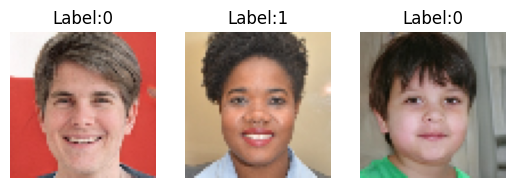

In [20]:
for batch, labels in train_dataset.take(1):
    batch = (batch + 1) / 2
    num_images = 3
    for i in range(num_images):
        plt.subplot(1,num_images,i+1)
        plt.imshow(batch[i])
        plt.title(f"Label:{labels[i]}")
        plt.axis("off")
    plt.show()

### Using images from generator.keras

In [ ]:
# Generating the fake images training data from the generator
def save_fake(output_dir,num_images=1000):
    generator = tf.keras.models.load_model("models/generator.keras")

    generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5),
                        loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    generated_images = generator.predict(tf.random.normal((num_images, latent_features, 1)),verbose=0)

    for i in range(num_images):
        image = generated_images[i]
        image = (image + 1) / 2
        image_path = os.path.join(output_dir, f"{i}.jpg")
        tf.keras.preprocessing.image.save_img(image_path, image)

    print(f"{i + 1} images generated and saved to {output_dir}.")

In [ ]:
save_fake("resnet_data/train/0",num_images=25000)
save_fake("resnet_data/valid/0",num_images=5000)
save_fake("resnet_data/test/0",num_images=10000)

In [ ]:
# Saving the real images in a different directory
def save_real(source_dir, destination_dir, num_images=1000):
    real_folder = os.path.join(source_dir, 'real')
    image_paths = [os.path.join(real_folder, filename) for filename in os.listdir(real_folder)]

    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    image_counter = 0
    for i, file_path in enumerate(image_paths):
        with Image.open(file_path) as img:
            output_path = os.path.join(destination_dir, f"{i}.jpg")
            img.save(output_path)
            image_counter += 1
        if image_counter >= num_images:
                break
    print(f"{num_images} images saved from {source_dir}to {destination_dir}.")

In [ ]:
save_real('real_vs_fake/real-vs-fake/train', "resnet_data/train/1", num_images=25000)
save_real('real_vs_fake/real-vs-fake/valid', "resnet_data/valid/1", num_images=5000)
save_real('real_vs_fake/real-vs-fake/test', "resnet_data/test/1", num_images=10000)

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "resnet_data/train",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(image_height, image_width),
    interpolation='gaussian',
    shuffle=True,
    seed=69,
)

In [ ]:
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "resnet_data/valid",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(image_height, image_width),
    interpolation='gaussian',
    shuffle=True,
    seed=69,
)

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "resnet_data/test",
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=(image_height, image_width),
    interpolation='gaussian',
    shuffle=True,
    seed=69,
)

In [ ]:
def augument(x, y):
    img = tf.cast(x, tf.float32)
    img = (img - 127.5) / 127.5
    return img, y

In [ ]:
train_dataset = train_dataset.map(augument)
valid_dataset = valid_dataset.map(augument)
test_dataset = test_dataset.map(augument)

In [ ]:
for batch, labels in train_dataset.take(1):
    batch = (batch + 1) / 2
    num_images = 3
    for i in range(num_images):
        plt.subplot(1,num_images,i+1)
        plt.imshow(batch[i])
        plt.title(f"Label:{labels[i]}")
        plt.axis("off")
    plt.show()

## EfficientNet

In [ ]:
from keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

effnet_clf = Model(inputs=base_model.input, outputs=predictions)
effnet_clf.summary()

In [ ]:
save_callback = ModelCheckpoint('effnet_clf_cp.keras'
                                ,save_weights_only=False
                                ,monitor='val_loss'
                                ,save_best_only=True)

effnet_clf.compile(optimizer=Adam()
                   ,loss='binary_crossentropy'
                   ,metrics=['accuracy'])

In [ ]:
# tf.keras.backend.clear_session()
effnet_clf_history = effnet_clf.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    callbacks=[save_callback],
)

In [ ]:
# Visualizing results
training_loss = effnet_clf_history.history['loss']
validation_loss = effnet_clf_history.history['val_loss']
training_accuracy = effnet_clf_history.history['accuracy']
validation_accuracy = effnet_clf_history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing set
# best_effnet_clf = load_model("effnet_clf_cp.h5")
test_loss, test_accuracy = effnet_clf.evaluate(test_dataset, verbose=0)
print(f"Test loss:{test_loss}")
print(f"Test accuracy:{test_accuracy}")

In [ ]:
# Saving final effnet model
effnet_clf.save("effnet_clf.keras", include_optimizer=True)

## GAN discriminator architecture

In [9]:
from keras.initializers import RandomNormal
from keras import models, layers, optimizers, losses

In [10]:
init = RandomNormal(stddev=0.02, seed=69)
discriminator = models.Sequential([
    layers.Conv2D(32, 4, 2, padding='same', input_shape = (image_width,image_height,3), 
                  kernel_initializer=init, use_bias=False),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.25),

    layers.Conv2D(64, 4, 2, padding='same', kernel_initializer=init, use_bias=False),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.25),

    layers.Conv2D(128, 4, 2, padding='same', kernel_initializer=init, use_bias=False),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.25),

    layers.Conv2D(256, 4, 2, padding='same', kernel_initializer=init, use_bias=False),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.25),

    layers.Conv2D(512, 4, 2, padding='same', kernel_initializer=init, use_bias=False),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.25),

    layers.Conv2D(1024, 2, 1, kernel_initializer=init, use_bias=False),
    layers.LeakyReLU(0.2),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

discriminator.compile(optimizer=optimizers.Adam(learning_rate=0.0002,beta_1=0.5),
                      loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [11]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1536      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32768     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         1

In [13]:
save_callback = tf.keras.callbacks.ModelCheckpoint('discriminator_non_gan_cp.h5'
                                ,save_weights_only=False
                                ,monitor='val_loss'
                                ,save_best_only=True)

In [14]:
# tf.keras.backend.clear_session()
discriminator_history = discriminator.fit(
    train_dataset,
    epochs=500,
    validation_data=valid_dataset,
    callbacks=[save_callback],
)

Epoch 1/500
196/196 [==============================] - 76s 300ms/step - loss: 0.5885 - accuracy: 0.6812 - val_loss: 0.5041 - val_accuracy: 0.7522
Epoch 2/500
195/196 [============================>.] - ETA: 0s - loss: 0.4792 - accuracy: 0.7730

KeyboardInterrupt: 

In [ ]:
# Visualizing results
training_loss = discriminator_history.history['loss']
validation_loss = discriminator_history.history['val_loss']
training_accuracy = discriminator_history.history['accuracy']
validation_accuracy = discriminator_history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing set
best_discriminator = models.load_model("discriminator_non_gan_cp.h5")
test_loss, test_accuracy = best_discriminator.evaluate(test_dataset, verbose=0)
print(f"Test loss:{test_loss}")
print(f"Test accuracy:{test_accuracy}")

~~Manual testing~~ obsolete

In [ ]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
def manual_prediction(img_path, model):
  img = image.load_img(img_path, target_size=(image_height, image_width))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  # Normalize pixel values to be between 0 and 1
  img_array /= 255.0

  # Make predictions
  prediction = model.predict(preprocess_input(img_array))

  plt.imshow(img)
  plt.title(f"Label:{prediction[0][0]}")

In [ ]:
manual_prediction("manual_test_images/Hard.jpeg",best_model)

In [ ]:
manual_prediction("manual_test_images/Medium.jpg",best_model)

In [ ]:
manual_prediction("manual_test_images/Easy.jpg",best_model)

In [ ]:
manual_prediction("manual_test_images/Real.jpg",best_model)